<a href="https://colab.research.google.com/github/stonewallmhk/QuantMindi/blob/main/SP500_Sector_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import datetime
import os

In [44]:
# prompt: increase output row length to extend to screen

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 900)

In [3]:
tickers_names = {
    "XLC": "Communication Services",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLK": "Technology",
    "XLU": "Utilities",
}

# 1. Function to fetch data for a given ticker symbol and commodity name
def fetch_data(ticker_symbol, commodity_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="1900-01-01", end=today)
    data.reset_index(inplace=True)

    # Check if the 'Date' column is of datetime type
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

    # Drop the unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits', 'Adj Close', 'Capital Gains'], inplace=True, errors='ignore')

    data['ticker'] = ticker_symbol
    data['sector'] = commodity_name

    # Convert other column names to lowercase
    data.columns = [col.lower() for col in data.columns]

    # Reorder columns to have 'ticker' and 'commodity' at the beginning
    data = data[['ticker', 'sector'] + [col for col in data.columns if col not in ['ticker', 'sector']]]

    return data


# 2. Loop over each symbol and append data to the master DataFrame
all_data = []
for symbol, name in tqdm(tickers_names.items(), desc="Fetching data"):  # tqdm progress bar!
    all_data.append(fetch_data(symbol, name))

# Concatenate all the individual datasets into one
master_data = pd.concat(all_data, ignore_index=True)

Fetching data: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


In [4]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62163 entries, 0 to 62162
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  62163 non-null  object 
 1   sector  62163 non-null  object 
 2   date    62163 non-null  object 
 3   open    62163 non-null  float64
 4   high    62163 non-null  float64
 5   low     62163 non-null  float64
 6   close   62163 non-null  float64
 7   volume  62163 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 3.8+ MB


In [5]:
master_data.head()

,ticker,sector,date,open,high,low,close,volume
0,XLC,Communication Services,2018-06-19,46.914391,47.254214,46.801118,47.159817,16600
1,XLC,Communication Services,2018-06-20,47.622357,48.036751,47.622357,47.745071,190000
2,XLC,Communication Services,2018-06-21,47.924418,47.999932,47.386366,47.452442,428700
3,XLC,Communication Services,2018-06-22,47.754508,47.773387,47.376926,47.660114,181500
4,XLC,Communication Services,2018-06-25,47.414683,47.414683,46.267782,46.678402,2509600


In [8]:
# prompt: Get the min and max date for every ticker

# Group by ticker and get the min and max date
min_max_dates = master_data.groupby('ticker')['date'].agg(['min', 'max'])

print(min_max_dates)


               min         max
ticker                        
XLB     1998-12-22  2024-09-24
XLC     2018-06-19  2024-09-24
XLE     1998-12-22  2024-09-24
XLF     1998-12-22  2024-09-24
XLI     1998-12-22  2024-09-24
XLK     1998-12-22  2024-09-24
XLP     1998-12-22  2024-09-24
XLRE    2015-10-08  2024-09-24
XLU     1998-12-22  2024-09-24
XLV     1998-12-22  2024-09-24
XLY     1998-12-22  2024-09-24


**Perform Analysis of an investment of USD 100 every month from 01-Jan-1999 till date with returns compunded annually**

#Step 1: Prepare Your Data

First, load your data into a pandas DataFrame and preprocess it by converting date strings to datetime objects, and exclude the tickers XLC and XLRE.

In [6]:
# Convert 'date' to datetime
master_data['date'] = pd.to_datetime(master_data['date'])

# Filter out specific tickers
filtered_data = master_data[~master_data['ticker'].isin(['XLC', 'XLRE'])]

# Ensure data is sorted by date for each ticker
filtered_data.sort_values(by=['ticker', 'date'], inplace=True)

<ipython-input-6-8050a132e9cc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['ticker', 'date'], inplace=True)


#Step 2: Calculate Monthly Investment Returns

To simulate the investment, you’ll need to resample the data to a monthly frequency, calculate the returns, and simulate the compounding investment.

In [7]:
filtered_data = filtered_data.reset_index()
filtered_data.head()

,index,ticker,sector,date,open,high,low,close,volume
0,40464,XLB,Materials,1998-12-22,11.750304,11.776809,11.732635,11.776809,1900
1,40465,XLB,Materials,1998-12-23,11.856317,11.953500,11.856317,11.900491,700
2,40466,XLB,Materials,1998-12-24,12.041854,12.174376,11.988845,12.174376,1500
3,40467,XLB,Materials,1998-12-28,12.156704,12.156704,12.050686,12.068356,2500
4,40468,XLB,Materials,1998-12-29,12.289227,12.289227,12.289227,12.289227,100


In [8]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58329 entries, 0 to 58328
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   58329 non-null  int64         
 1   ticker  58329 non-null  object        
 2   sector  58329 non-null  object        
 3   date    58329 non-null  datetime64[ns]
 4   open    58329 non-null  float64       
 5   high    58329 non-null  float64       
 6   low     58329 non-null  float64       
 7   close   58329 non-null  float64       
 8   volume  58329 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 4.0+ MB


In [9]:
# Set 'date' as the index if not already
filtered_data.set_index('date', inplace=True)

In [18]:
# prompt: group by ticker and resample to monthly using the last available price

monthly_prices = filtered_data.groupby('ticker')['close'].resample('M').last()


In [19]:
monthly_prices = monthly_prices.reset_index()
monthly_prices.set_index('date', inplace=True)
monthly_prices.head()

,ticker,close
date,,
1998-12-31,XLB,12.395250
1999-01-31,XLB,11.935834
1999-02-28,XLB,12.121371
1999-03-31,XLB,12.339423
1999-04-30,XLB,15.388819


In [23]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2790 entries, 1998-12-31 to 2024-09-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  2790 non-null   object 
 1   close   2790 non-null   float64
dtypes: float64(1), object(1)
memory usage: 129.9+ KB


In [26]:
# Calculating monthly returns
monthly_prices['returns'] = monthly_prices.groupby('ticker')['close'].pct_change()
print(monthly_prices.head())
print(monthly_prices.info())

           ticker      close   returns
date                                  
1998-12-31    XLB  12.395250       NaN
1999-01-31    XLB  11.935834 -0.037064
1999-02-28    XLB  12.121371  0.015545
1999-03-31    XLB  12.339423  0.017989
1999-04-30    XLB  15.388819  0.247126
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2790 entries, 1998-12-31 to 2024-09-30
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ticker   2790 non-null   object 
 1   close    2790 non-null   float64
 2   returns  2781 non-null   float64
dtypes: float64(2), object(1)
memory usage: 151.7+ KB
None


**Simulate Monthly Investment**

In [35]:
investment_df = monthly_prices.copy()
investment_df['investment_value'] = 0
investment_df.head()

,ticker,close,returns,investment_value
date,,,,
1998-12-31,XLB,12.395250,NaN,0
1999-01-31,XLB,11.935834,-0.037064,0
1999-02-28,XLB,12.121371,0.015545,0
1999-03-31,XLB,12.339423,0.017989,0
1999-04-30,XLB,15.388819,0.247126,0


In [36]:
investment_df = investment_df.set_index('ticker', append=True)
investment_df.head()

,,close,returns,investment_value
date,ticker,,,
1998-12-31,XLB,12.395250,NaN,0
1999-01-31,XLB,11.935834,-0.037064,0
1999-02-28,XLB,12.121371,0.015545,0
1999-03-31,XLB,12.339423,0.017989,0
1999-04-30,XLB,15.388819,0.247126,0


In [39]:
# Loop through each month and ticker, updating the investment values
monthly_investment = 100
for (date, ticker), row in investment_df.iterrows():
    if date.year not in investment_df.columns:
        # Add a new column for each year
        investment_df[date.year] = 0
    # Add monthly investment and calculate compounded annual returns
    previous_year = date.year - 1
    if previous_year in investment_df.columns:
        # Update the current year's investment with last year's compounded result
        previous_investment = investment_df.at[(date, ticker), previous_year] * (1 + investment_df.at[(date, ticker), 'returns'])
        investment_df.at[(date, ticker), date.year] = previous_investment + monthly_investment
    else:
        # No compounding needed, just add the investment
        investment_df.at[(date, ticker), date.year] = investment_df.at[(date, ticker), 'investment_value'] + monthly_investment

In [40]:
investment_df.head(20)

,,close,returns,investment_value,1998,1999,2000,2001,2002,2003,2004,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
date,ticker,,,,,,,,,,,,,,,,,,,,,
1998-12-31,XLB,12.395250,NaN,0,100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-01-31,XLB,11.935834,-0.037064,0,0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-02-28,XLB,12.121371,0.015545,0,0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-03-31,XLB,12.339423,0.017989,0,0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-04-30,XLB,15.388819,0.247126,0,0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-05-31,XLB,13.988229,-0.091013,0,0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-06-30,XLB,14.796581,0.057788,0,0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-07-31,XLB,14.627630,-0.011418,0,0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999-08-31,XLB,13.969611,-0.044985,0,0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# At the end of each year, calculate the compounded investment
for year in investment_df.columns:
  if isinstance(year, int):  # Ensure it's a year column
    #print(f'YEAR -- {year}')
    year_end_date = pd.Timestamp(year=year, month=12, day=31)
    if year_end_date in investment_df.index.get_level_values('date'):
      # Apply the annual compound rate
      investment_df[year] = investment_df[year] * (1 + investment_df.loc[year_end_date, 'returns'])


In [61]:
investment_df.head(20)

,,close,returns,investment_value,1998,1999,2000,2001,2002,2003,2004,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
date,ticker,,,,,,,,,,,,,,,,,,,,,
1998-12-31,XLB,12.395250,NaN,0,NaN,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1999-01-31,XLB,11.935834,-0.037064,0,NaN,111.57112,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1999-02-28,XLB,12.121371,0.015545,0,NaN,111.57112,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1999-03-31,XLB,12.339423,0.017989,0,NaN,111.57112,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1999-04-30,XLB,15.388819,0.247126,0,NaN,111.57112,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1999-05-31,XLB,13.988229,-0.091013,0,NaN,111.57112,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1999-06-30,XLB,14.796581,0.057788,0,NaN,111.57112,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1999-07-31,XLB,14.627630,-0.011418,0,NaN,111.57112,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1999-08-31,XLB,13.969611,-0.044985,0,NaN,111.57112,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [62]:
investment_df['total_investment'] = investment_df.sum(axis=1)

In [66]:
# prompt: show data for ticker XLB with colmns close, investment_value and total_investment

# Assuming 'investment_df' is your DataFrame with the investment calculations
xlb_data = investment_df.loc[(slice(None), 'XLB'), ['close', 'investment_value', 'total_investment']]
print(xlb_data)


                       close  investment_value  total_investment
date       ticker                                               
1998-12-31 XLB     12.395250                 0         12.395250
1999-01-31 XLB     11.935834                 0        123.469890
1999-02-28 XLB     12.121371                 0        123.708036
1999-03-31 XLB     12.339423                 0        123.928532
1999-04-30 XLB     15.388819                 0        127.207065
1999-05-31 XLB     13.988229                 0        125.468335
1999-06-30 XLB     14.796581                 0        126.425489
1999-07-31 XLB     14.627630                 0        126.187332
1999-08-31 XLB     13.969611                 0        125.495747
1999-09-30 XLB     13.531497                 0        125.071255
1999-10-31 XLB     13.852612                 0        125.447462
1999-11-30 XLB     13.656374                 0        125.213328
1999-12-31 XLB     15.236569                 0        126.923401
2000-01-31 XLB     13.373

In [55]:
monthly_prices['cum_returns'] = (1 + monthly_prices['returns']).groupby(monthly_prices['ticker']).cumprod()
print(monthly_prices.head())
print(monthly_prices.info())

  ticker       date      close   returns  cum_returns
0    XLB 1998-12-31  12.395247       NaN          NaN
1    XLB 1999-01-31  11.935836 -0.037063     0.962937
2    XLB 1999-02-28  12.121361  0.015544     0.977904
3    XLB 1999-03-31  12.339417  0.017989     0.995496
4    XLB 1999-04-30  15.388824  0.247127     1.241510
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2790 entries, 0 to 2789
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ticker       2790 non-null   object        
 1   date         2790 non-null   datetime64[ns]
 2   close        2790 non-null   float64       
 3   returns      2781 non-null   float64       
 4   cum_returns  2781 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 109.1+ KB
None


In [65]:
# prompt: groupby ticker and get the cum_returns from previous row

monthly_prices['previous_cum_returns'] = monthly_prices.groupby('ticker')['cum_returns'].shift(1)


KeyError: 'Column not found: -1'

In [66]:
#Absolute growth
monthly_prices['absolute_growth'] = (monthly_prices.groupby('ticker')['cum_returns'].shift(1) - 1) * 100
print(monthly_prices.head())
print(monthly_prices.info())

  ticker       date      close   returns  cum_returns  absolute_growth
0    XLB 1998-12-31  12.395247       NaN          NaN              NaN
1    XLB 1999-01-31  11.935836 -0.037063     0.962937              NaN
2    XLB 1999-02-28  12.121361  0.015544     0.977904        -3.706346
3    XLB 1999-03-31  12.339417  0.017989     0.995496        -2.209603
4    XLB 1999-04-30  15.388824  0.247127     1.241510        -0.450407
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2790 entries, 0 to 2789
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ticker           2790 non-null   object        
 1   date             2790 non-null   datetime64[ns]
 2   close            2790 non-null   float64       
 3   returns          2781 non-null   float64       
 4   cum_returns      2781 non-null   float64       
 5   absolute_growth  2772 non-null   float64       
dtypes: datetime64[ns](1), float64(4), objec

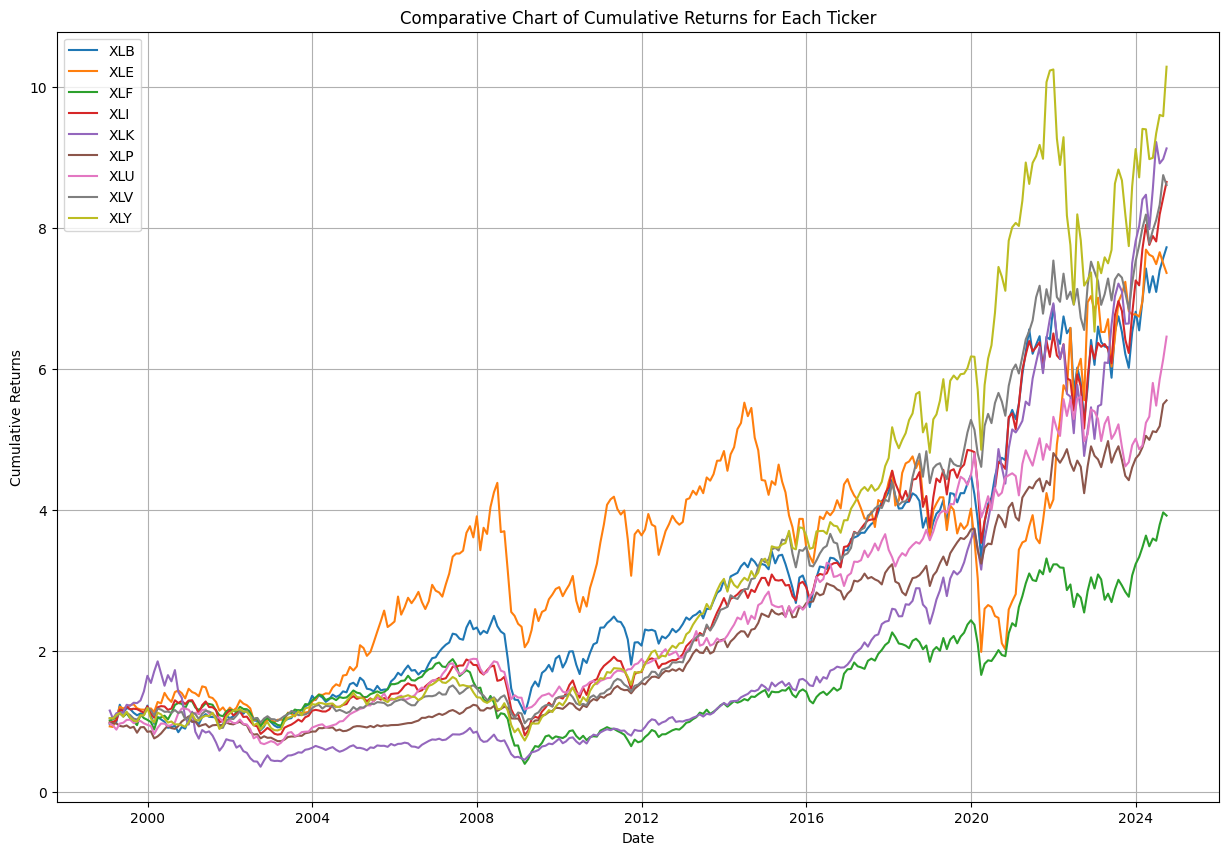

In [60]:
# prompt: plot a comparitive chart for cumulative returns for each ticker and the figsize should be 15, 10

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for ticker in monthly_prices['ticker'].unique():
  ticker_data = monthly_prices[monthly_prices['ticker'] == ticker]
  plt.plot(ticker_data['date'], ticker_data['cum_returns'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Comparative Chart of Cumulative Returns for Each Ticker')
plt.legend()
plt.grid(True)
plt.show()


In [62]:
monthly_prices.head(20)

,ticker,date,close,returns,cum_returns
0,XLB,1998-12-31,12.395247,NaN,NaN
1,XLB,1999-01-31,11.935836,-0.037063,0.962937
2,XLB,1999-02-28,12.121361,0.015544,0.977904
3,XLB,1999-03-31,12.339417,0.017989,0.995496
4,XLB,1999-04-30,15.388824,0.247127,1.241510
5,XLB,1999-05-31,13.988230,-0.091014,1.128516
6,XLB,1999-06-30,14.796587,0.057788,1.193731
7,XLB,1999-07-31,14.627630,-0.011419,1.180100
8,XLB,1999-08-31,13.969614,-0.044984,1.127014
9,XLB,1999-09-30,13.531505,-0.031362,1.091669


In [29]:
# Prepare to track investment across years
# Assuming you start investing in 1999 and end in the latest year available in your data
start_year = 1999
end_year = monthly_prices.index.get_level_values('date').max().year
print(end_year)


2024


In [30]:
# Initialize an investment tracker DataFrame
investment_value = pd.DataFrame(index=pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq='M'))

# Populate the investment for each year
for year in range(start_year, end_year + 1):
    investment_value[year] = 100  # Monthly investment of USD 100

# Flatten the DataFrame to multiply across all years each month
investment_value = investment_value.cumsum()

In [34]:
investment_value

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
1999-01-31,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1999-02-28,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
1999-03-31,300,300,300,300,300,300,300,300,300,300,...,300,300,300,300,300,300,300,300,300,300
1999-04-30,400,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,400
1999-05-31,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,30800,30800,30800,30800,30800,30800,30800,30800,30800,30800,...,30800,30800,30800,30800,30800,30800,30800,30800,30800,30800
2024-09-30,30900,30900,30900,30900,30900,30900,30900,30900,30900,30900,...,30900,30900,30900,30900,30900,30900,30900,30900,30900,30900
2024-10-31,31000,31000,31000,31000,31000,31000,31000,31000,31000,31000,...,31000,31000,31000,31000,31000,31000,31000,31000,31000,31000
2024-11-30,31100,31100,31100,31100,31100,31100,31100,31100,31100,31100,...,31100,31100,31100,31100,31100,31100,31100,31100,31100,31100


In [32]:
# prompt: calculate the investment value over time

# Calculate the investment value over time for each ticker
investment_values = {}
for ticker in monthly_returns.columns.levels[0]:
  investment_value = 100  # Starting investment
  investment_values_ticker = []
  for date, monthly_return in monthly_returns[ticker].dropna().iteritems():
    investment_value = investment_value * (1 + monthly_return) + 100
    investment_values_ticker.append((date, investment_value))
  investment_values[ticker] = pd.DataFrame(investment_values_ticker, columns=['date', 'investment_value'])

# Concatenate investment values for all tickers into a single DataFrame
investment_values_df = pd.concat([df.set_index('date') for df in investment_values.values()], axis=1, keys=investment_values.keys())

# Display the investment values over time
print(investment_values_df.head())


AttributeError: 'Series' object has no attribute 'columns'

In [31]:
# Calculate the investment value over time
for month in investment_value.index:
    year = month.year
    current_investment = investment_value.at[month, year]
    monthly_return = monthly_prices.loc[(slice(None), month), 'monthly_returns'].mean()
    investment_value.loc[month] = current_investment * (1 + monthly_return)

# Sum across all years for total value
investment_value['total_value'] = investment_value.sum(axis=1)

IndexingError: Too many indexers